# generate "3d" points from 2d trajectories

In [108]:
# Read png file. Black Background with white trajectory

import numpy as np
import cv2
import matplotlib.pyplot as plt

RIBBON_LEN = 128
RIBBON_ROWS = 8
upper_img = 'assets/scroller/path-upper.png'
lower_img ='assets/scroller/path-lower.png'
OUT_DATA_FILE = '../data/scroller_data.inc'

ribbon_points: list[list[tuple[int, int]]] = [[] for _ in range(RIBBON_ROWS)]

def get_points_from_image(filename: str) -> list[tuple[int, int]]:  # [(x, y), ...]
    # Read image
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    # Follow the white path from left to right and create a list of RIBBON_LEN equidistant points
    # Iterate over columns from first to last
    all_points = []
    for i in range(img.shape[1]):
        # get column
        col = img[:, i]
        # print indexes of all white pixels
        white = np.where(col > 25)[0]
        # Find middle of white pixels by averaging the indexes and rounding to integer
        pnt = int(np.mean(white)) 
        all_points.append((i, pnt))
    return all_points

# calculate physical distance between center of points. Output a list of accumulative lengths.
def calculate_length(points: list[tuple[int, int]]) -> list[float]:
    lengths:list[float] = [.0]
    length: float = 0
    for i in range(len(points)-1):
        x1, y1 = points[i]
        x2, y2 = points[i+1]
        length += np.sqrt((x2-x1)**2 + (y2-y1)**2)
        lengths.append(length)
    return lengths

# find RIBBON_LEN equidistant points on the path
def calculate_ribbon_row(lengths: list[float], step: float, upper_points: list[tuple[int, int]]) -> list[tuple[int, int]]:
    ribbon_row: list[tuple[int, int]] = []
    for i in range(RIBBON_LEN):  # columns
        # find the point on the path where the distance is i * upper_step
        upper_index = 0
        while lengths[upper_index] < i * step:
            upper_index += 1
        # interpolate the points
        upper_x, upper_y = upper_points[upper_index]
        ribbon_row.append((upper_x, upper_y))
    assert len(ribbon_row) == RIBBON_LEN
    return ribbon_row

# for each column of ribbon points, take upmost and lowermost points and interpolate 6 points in between them
def interpolate_points():
    global ribbon_points
    assert len(ribbon_points[0]) == RIBBON_LEN
    assert len(ribbon_points[7]) == RIBBON_LEN
    for i in range(RIBBON_LEN):
        upper_x, upper_y = ribbon_points[0][i]
        lower_x, lower_y = ribbon_points[7][i]
        for j in range(1, 7):
            x = upper_x + (lower_x - upper_x) * j / 7
            y = upper_y + (lower_y - upper_y) * j / 7
            ribbon_points[j].append((int(x), int(y)))

In [109]:
upper_points = get_points_from_image(upper_img)
lower_points = get_points_from_image(lower_img)
upper_lengths = calculate_length(upper_points)
lower_lengths = calculate_length(lower_points)
upper_step = upper_lengths[-1] / RIBBON_LEN  # get total length of path as reported by the last element of the list (first column)
lower_step = lower_lengths[-1] / RIBBON_LEN
assert len(upper_lengths) == len(upper_points)
assert len(lower_lengths) == len(lower_points)

# ribbon_points contains RIBBON_ROWS rows of RIBBON_LEN points each. Point is defined as tuple (x, y). Row 0 is the top row.
ribbon_points[0] = calculate_ribbon_row(upper_lengths, upper_step, upper_points)
ribbon_points[7] = calculate_ribbon_row(lower_lengths, lower_step, lower_points)
interpolate_points()

/tmp/ipykernel_3897366/1927862239.py:11: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 256 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  orig_img[y + dy, x + dx] = 256 - i


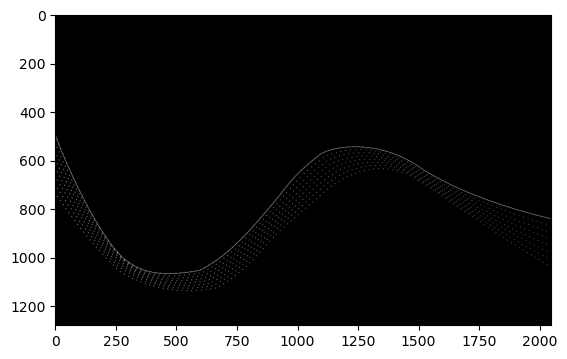

In [110]:
# Plot the ribbon points to the original image and output assembler data
# colors will be shades of gray starting intensity 256 down to 128 and will decrease by one for each column

orig_img = cv2.imread(upper_img, cv2.IMREAD_GRAYSCALE)
for i in range(RIBBON_LEN):
    for j in range(RIBBON_ROWS):
        x, y = ribbon_points[j][i]
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                if 0 <= y + dy < orig_img.shape[0] and 0 <= x + dx < orig_img.shape[1]:
                    orig_img[y + dy, x + dx] = 256 - i
plt.imshow(orig_img, cmap='gray')
plt.show()

with open(OUT_DATA_FILE, 'w') as f:
    # Output assembler data in hex( //.byte low x pos, y pos, hi x pos ...) each assembler line will have 8 points (whole column)
    for i in range(RIBBON_LEN):
        line_data = []
        for j in range(RIBBON_ROWS):
            x, y = ribbon_points[j][i]
            # scale down to resolution of 320x200
            x = x * 320 // orig_img.shape[1]
            y = y * 200 // orig_img.shape[0]
            line_data.append(f'${x & 0xff:02x}, ${y & 0xff:02x}, ${x >> 8:02x}')
        # print(f'.byte ' + ', '.join(line_data))
        f.write(f'.byte ' + ', '.join(line_data) + '\n')
